In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
from graphviz import Digraph
from collections import defaultdict
sys.setrecursionlimit(10000)
%matplotlib inline

In [2]:
attributes_train = ['child_id', 'scorer_id', 'question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'diag']
attributes_test = ['child_id', 'scorer_id', 'question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'ASD']
train, test = pd.read_csv('./Tariq-Wall-2018-PLOS-MEDICINE/datasets/primary_dataset.csv'), pd.read_csv('./Tariq-Wall-2018-PLOS-MEDICINE/datasets/validation_dataset.csv')
train, test = train[attributes_train], test[attributes_test]

In [3]:
def get_children_to_index(data_frame):
    child_to_index = defaultdict(list)
    
    for index in range(data_frame.shape[0]):
        row = data_frame.iloc[index]
        child_to_index[row['child_id']].append(index)
    
    
    return child_to_index


In [4]:
# remove bad data from train
def remove_nan(data_frame):
    question_stub = "question"
    to_remove = []
    for index in data_frame.index.tolist():
        valid = True
        row = data_frame.loc[index]
        for j in range(1,31):
            question = question_stub + str(j)
            value = row[question]
            if(value != value):
                valid = False
        if(not valid):
            to_remove.append(index)
    
    return to_remove

to_remove = remove_nan(train)
train.drop(to_remove, inplace=True)

def remove_underrepresented_data(data_frame):
    child_to_counts = defaultdict(int)
    
    for x in range(data_frame.shape[0]):
        row = data_frame.iloc[x]
        child_to_counts[row['child_id']] += 1
    
    to_remove = []
    too_many = []
    for child, count in child_to_counts.items():
        if(count < 3):
            to_remove.append(child)
        
        if(count > 3):
            too_many.append(child)
            
    
    
    to_remove_index = []
    for index in data_frame.index.tolist():
        child = data_frame.loc[index]['child_id']
        if(child in to_remove):
            to_remove_index.append(index)
        
        if(child in too_many):
            to_remove_index.append(index)
            too_many.remove(child)
        
        
    
    return to_remove_index
        

In [5]:
to_remove = remove_underrepresented_data(train)
train.drop(to_remove, inplace=True)

to_remove = remove_underrepresented_data(test)
test.drop(to_remove, inplace=True)
child_to_index_train = get_children_to_index(train)
child_to_index_test = get_children_to_index(test)
#child_to_index_test = get_children_to_index(test)

attributes_test = ['question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'ASD']
test = test[attributes_test]

attributes_train = ['question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'diag']
train = train[attributes_train]
train.shape, test.shape

((480, 31), (201, 31))

In [6]:
# upsample or downsample data
def upsample(data_frame):
    min_pop = data_frame.loc[data_frame['diag'] == 'non-asd']
    maj_pop = data_frame.loc[data_frame['diag'] == 'asd']
    sample_size = maj_pop.shape[0] - min_pop.shape[0]
    
    indices = min_pop.index.tolist()
    
    # sample minority population with replacement
    sample = random.choices(population=indices, k=sample_size)
    
    return sample

sample = upsample(train)

for idx in sample: # hacky way to append to pandas dataframe without copying..
    train.loc[train.index.max() + 1] = train.loc[idx]

In [7]:
# populations equally represented now??
assert(train.loc[train['diag'] == 'asd'].shape == train.loc[train['diag'] == 'non-asd'].shape)
print(train.shape)
print(test.shape)

(654, 31)
(201, 31)


In [8]:
data_train, data_test = train.values, test.values

In [9]:
#feature selection for 4, and 8 features
LABEL_IDX = -1
def is_single_class(data):
    return len(np.unique(data[:,LABEL_IDX])) == 1

def classify(data):
    classes, counts = np.unique(data[:, LABEL_IDX], return_counts=True)
    return int(classes[np.argmax(counts)] == 'asd')

In [10]:
is_single_class(data_train)
classify(data_train)

1

In [11]:
from collections import defaultdict
def get_data_partitions(data, features=None):
    
    #all features
    if(features == None):
        features = np.arange(0, data.shape[1]-1)
        
    partitions = defaultdict(list)
    for idx in range(0, data.shape[1]-1):
        # one of selected features?
        if(idx in features):
            unique_scores = np.unique(data[:, idx])
            '''
            if(len(unique_scores) == 1): # edge case what if unique score == 1
                partitions[idx].append(unique_scores[0])
            '''
            for x in range(len(unique_scores)-1):
                divide = np.mean(unique_scores[x:x+2])
                partitions[idx].append(divide)
        else:
            continue
        
    return partitions

In [12]:
data_partitions = get_data_partitions(data_train)

In [13]:
def partition_data(data, question, score):
    a,b = data[data[:, question] >= score], data[data[:, question] < score]
    
    return a,b
    
    

In [14]:
a, b = partition_data(data_train, 0, .5)
def get_entropy(data):
    _, counts = np.unique(data[:, LABEL_IDX], return_counts=True)
    p_i = counts / sum(counts)
    return (p_i * -np.log2(p_i)).sum() # entropy sum(p_i * -log2(p_i))
    

In [15]:
def get_total_entropy(a, b):
    n = a.shape[0] + b.shape[0]
    p_a, p_b = a.shape[0] / n, b.shape[0] / n
    entropy_a, entropy_b = get_entropy(a), get_entropy(b)
    return p_a*entropy_a + p_b*entropy_b
    

In [16]:
get_total_entropy(a,b)

0.9261503808409962

In [17]:
def lowest_entropy_partition(data, data_partitions):
    
    lowest = np.inf
    split_question = None
    split_score = None
    
    for question in data_partitions:
        cutoffs = data_partitions[question]
        for score in cutoffs:
            a,b = partition_data(data, question, score)
            entropy = get_total_entropy(a,b)
            if(entropy < lowest):
                lowest = entropy
                split_question = question
                split_score = score
    
    return split_question, split_score, lowest
                

In [18]:
split_question, split_score, lowest_entropy = lowest_entropy_partition(data_train, data_partitions)

In [19]:
split_question, split_score, lowest_entropy

(24, 2.5, 0.6178475531607428)

In [20]:
class Queue(object):
    def __init__(self):
        self.queue = []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        self.queue[0], self.queue[-1] = self.queue[-1], self.queue[0]
        
        return self.queue.pop()
    
    def peek(self):
        if(not self.is_empty()):
            return self.queue[0]
    
    def is_empty(self):
        return len(self.queue) == 0
    
    def size(self):
        return len(self.queue)

In [21]:
def select_k_lowest_features(data, k):
    features = set()
    q = Queue()
    q.enqueue(data)
    while(len(features) < k):
        size = q.size()
        for x in range(size):
            data = q.dequeue()
            
            data_partitions = get_data_partitions(data)
            
            if(len(features) == k):
                break
                
            feature, value, _ = lowest_entropy_partition(data, data_partitions)
            if(feature != None):
                features.add(feature)
                a, b = partition_data(data, feature, value)
                q.enqueue(a)
                q.enqueue(b)
            else:
                #print(data, data_partitions)
                continue
    features = list(features)
    #print(len(features))
    return features[0:k+1]
        

In [22]:
features_8 = select_k_lowest_features(data_train, k=8)

In [23]:
features_6 = select_k_lowest_features(data_train, k=6)

In [24]:
features_4 = select_k_lowest_features(data_train, k=4)

In [25]:
class TreeNode(object):
    def __init__(self, feature, value, id=None):
        self.question = "%s >= %0.2f" % (feature, value)
        self.feature = feature
        self.value = value
        self.yes = None
        self.no = None
        self.id = id
    
    def __str__(self):
        return self.question
    
    def set_id(self, id):
        self.id = id
    def get_id(self):
        return str(self.id)
        
def get_decision_tree(data, features=None):
    
    if(is_single_class(data)):
        return classify(data)
    else:
        # get question, and cutoff with lowest overall entropy
        data_partitions = get_data_partitions(data, features)
        split_question, split_value, lowest_entropy = lowest_entropy_partition(data, data_partitions)
        
        # no way to split the data with given features.. so return best guess
        if(split_question == None):
            print("Model performing best guess for leaf node..")
            return classify(data)
            '''
            for x in range(0, data.shape[1]-1):
                if(x in features):
                    print(data[:,x].shape)
                    unique_scores = np.unique(data[:, x])
                    print(x, data[:,x])
                    print(unique_scores)
            '''     
        node = TreeNode(split_question, split_value)
        a, b = partition_data(data, split_question, split_value)
        
        # recurse on left, and right subtrees..
        node.yes = get_decision_tree(a, features)
        node.no = get_decision_tree(b, features)
        
        return node


In [26]:
tree_all = get_decision_tree(data_train)
tree_8 = get_decision_tree(data_train, features=features_8)
tree_6 = get_decision_tree(data_train, features=features_6)
tree_4 = get_decision_tree(data_train, features=features_4)

Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for 

In [27]:
def bfs(root, title="Default Title"):
    q = Queue()
    G = Digraph(comment=title)
    
    cur_id = 0
    q.enqueue(root)
    G.node(str(cur_id), root.question)
    root.set_id(cur_id)
    cur_id += 1
    while(not q.is_empty()):
        size = q.size()
        
        # process that lvl
        for x in range(size):
            node = q.dequeue()
            
            #print(node, end='\t\t')
            # enqueue children if not classification
            if(type(node) != int):
                # build up the graph..
                if(type(node.yes) != int):
                    node.yes.set_id(cur_id)
                    G.node(str(cur_id), node.yes.question)
                    G.edge(node.get_id(), node.yes.get_id(), label='y')
                else:
                    G.node(str(cur_id), str(node.yes), shape='square')
                    G.edge(node.get_id(), str(cur_id), label='y')
                cur_id += 1
                
                
                if(type(node.no) != int):
                    node.no.set_id(cur_id)
                    G.node(str(cur_id), str(node.no))
                    G.edge(node.get_id(), node.no.get_id(), label='n')
                else:
                    G.node(str(cur_id), str(node.no), shape='square')
                    G.edge(node.get_id(), str(cur_id), label='n')
                    
                cur_id += 1
                
                    
                q.enqueue(node.yes)
                q.enqueue(node.no)
            else:
                continue
            
            
        # next level please..
        #print("\n\n")
    
    return G

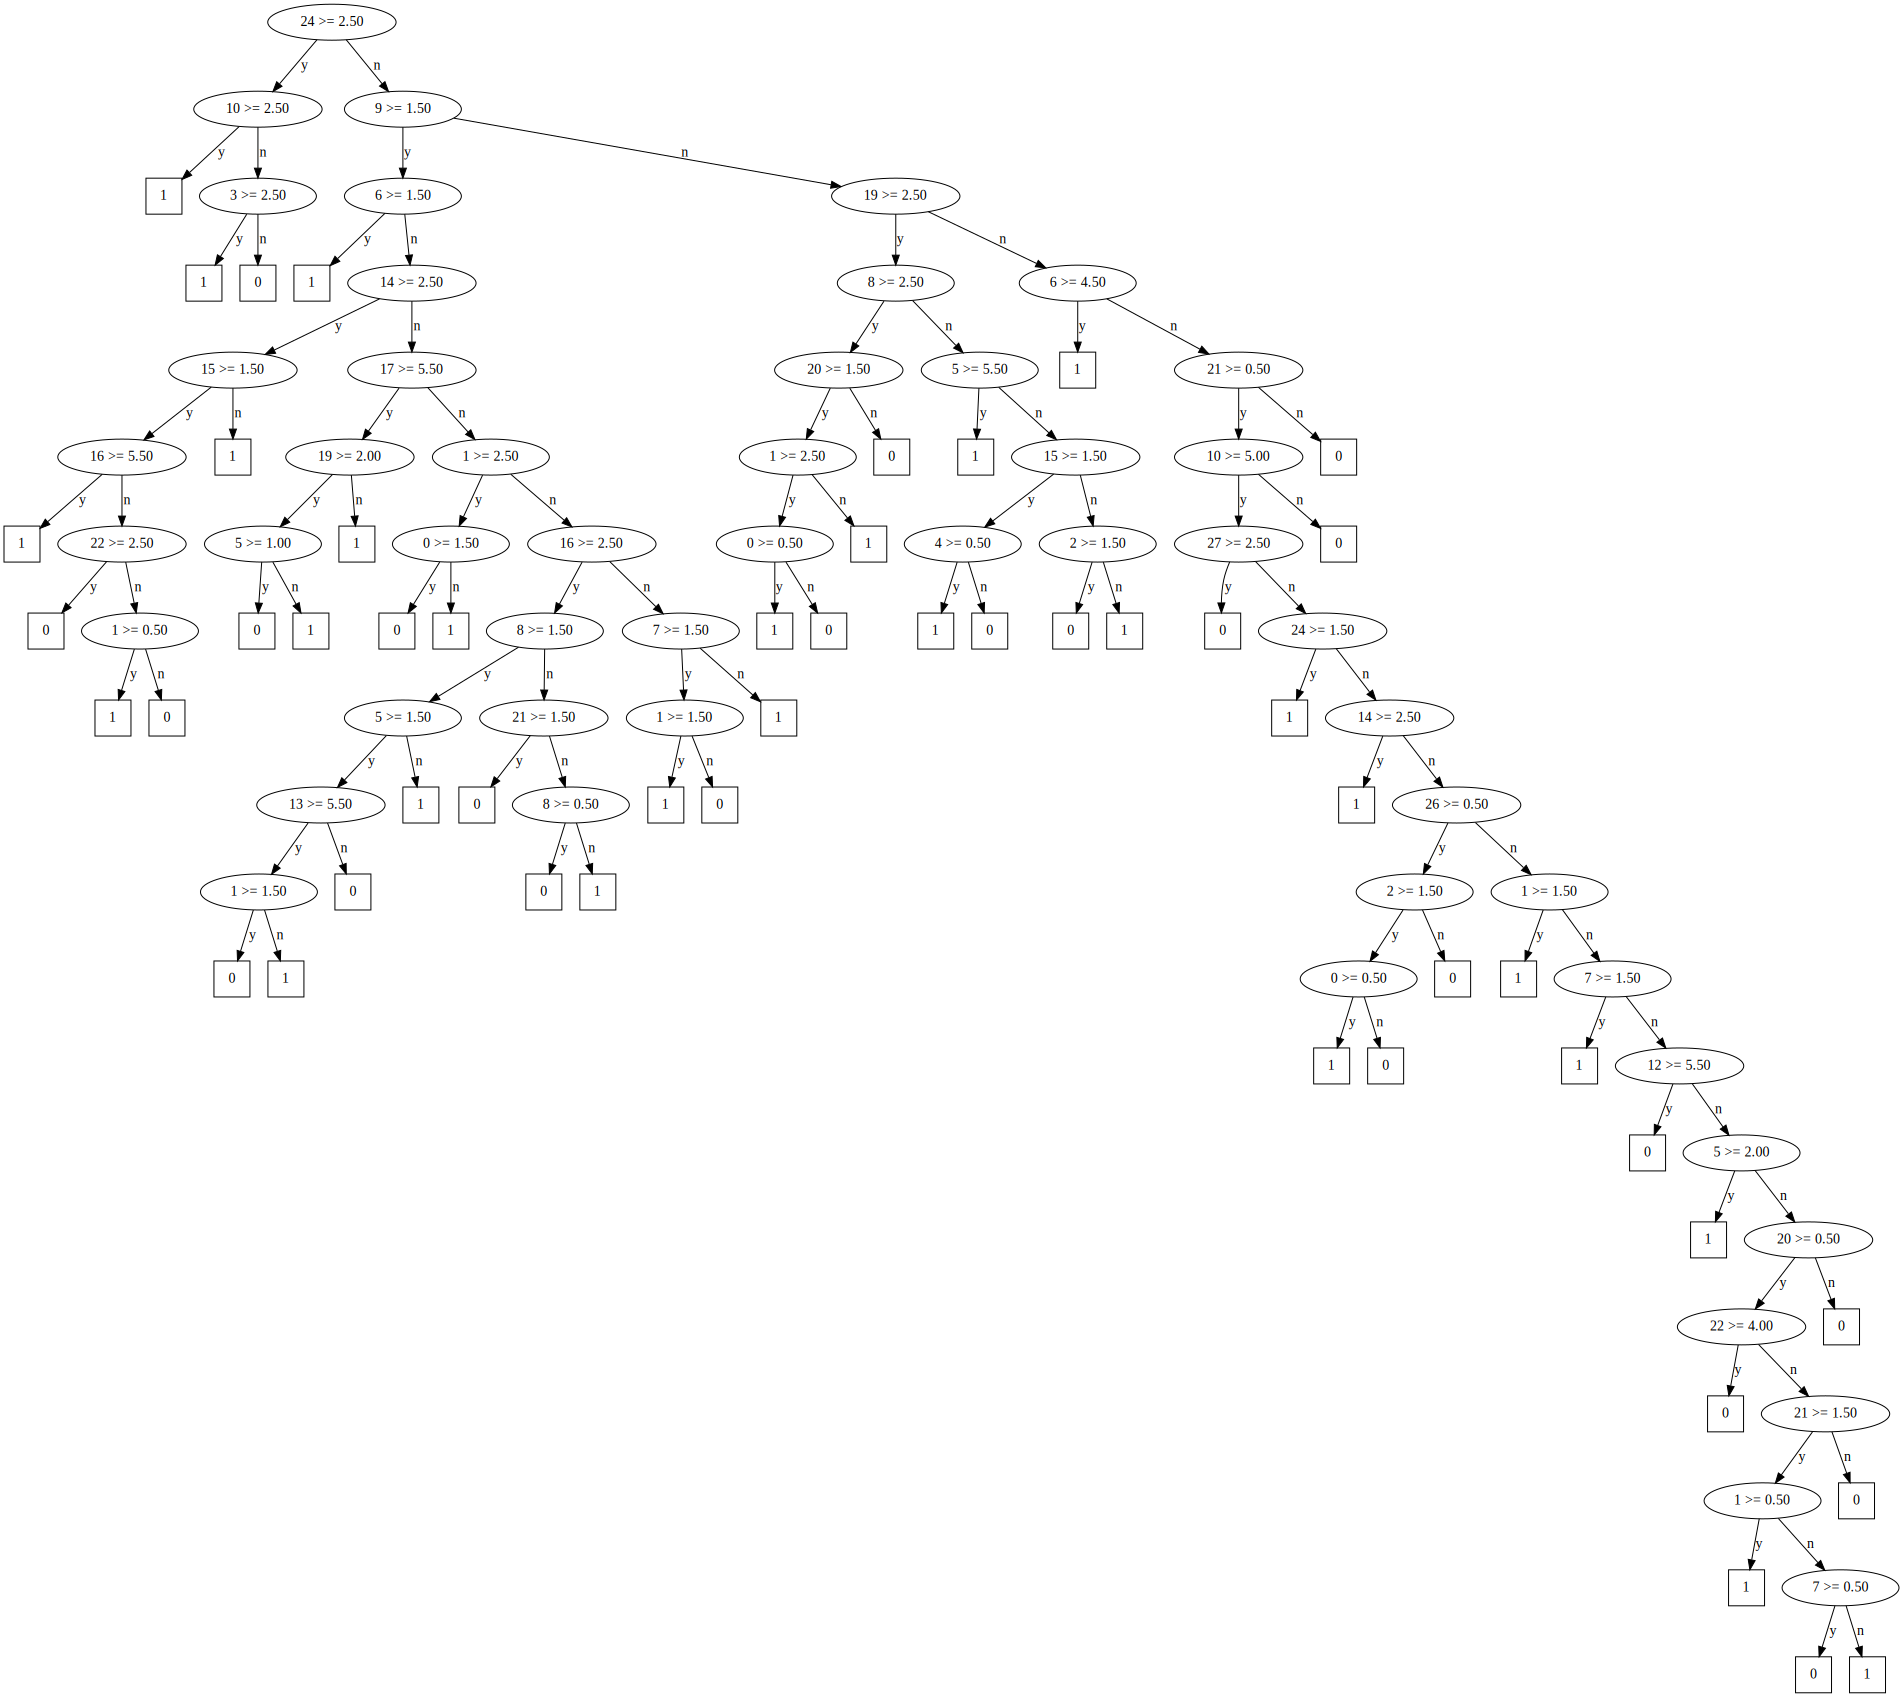

In [28]:
tree_all_g = bfs(tree_all)
tree_all_g

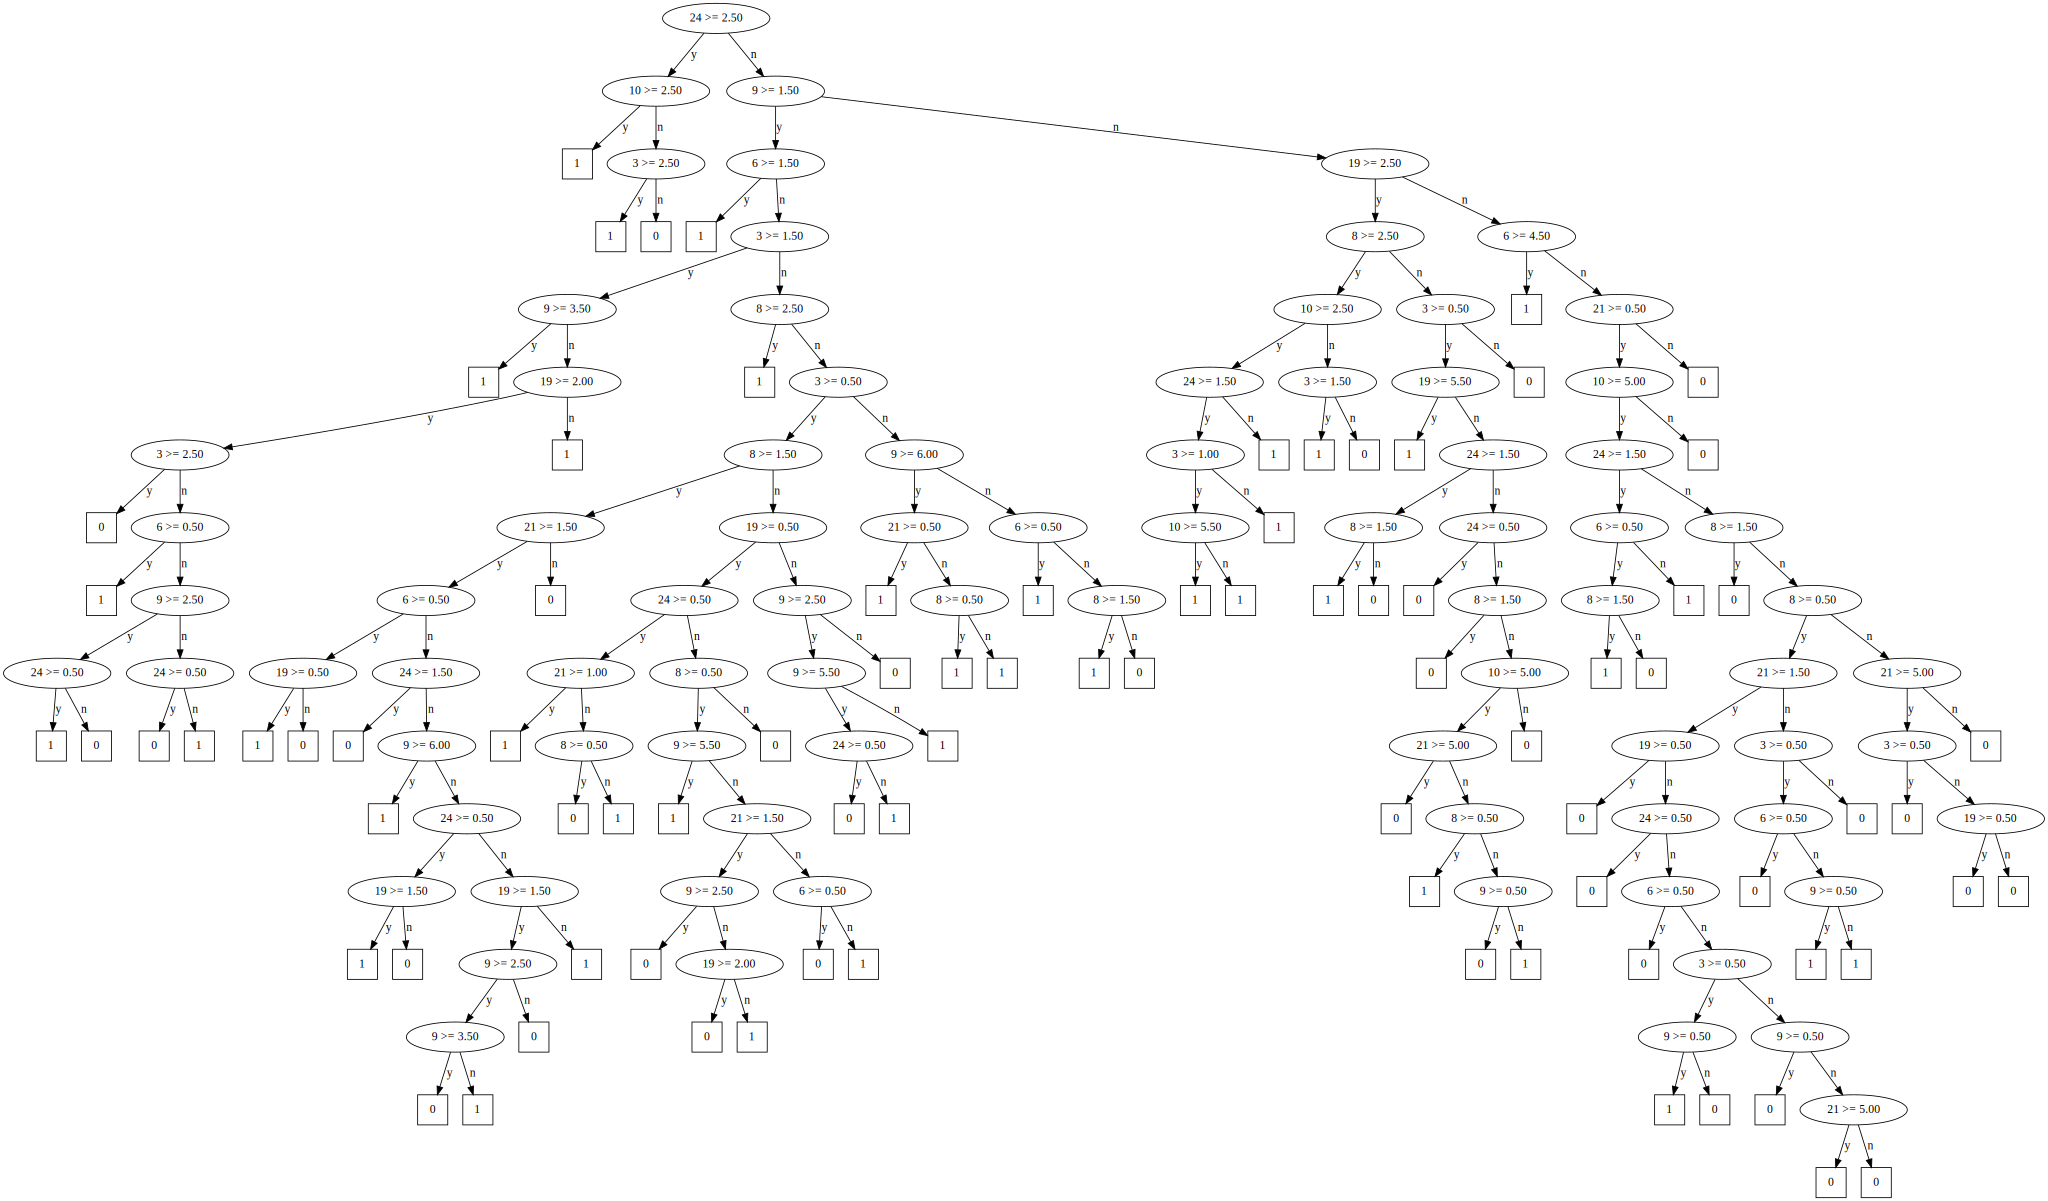

In [29]:
tree_8_g = bfs(tree_8)
tree_8_g

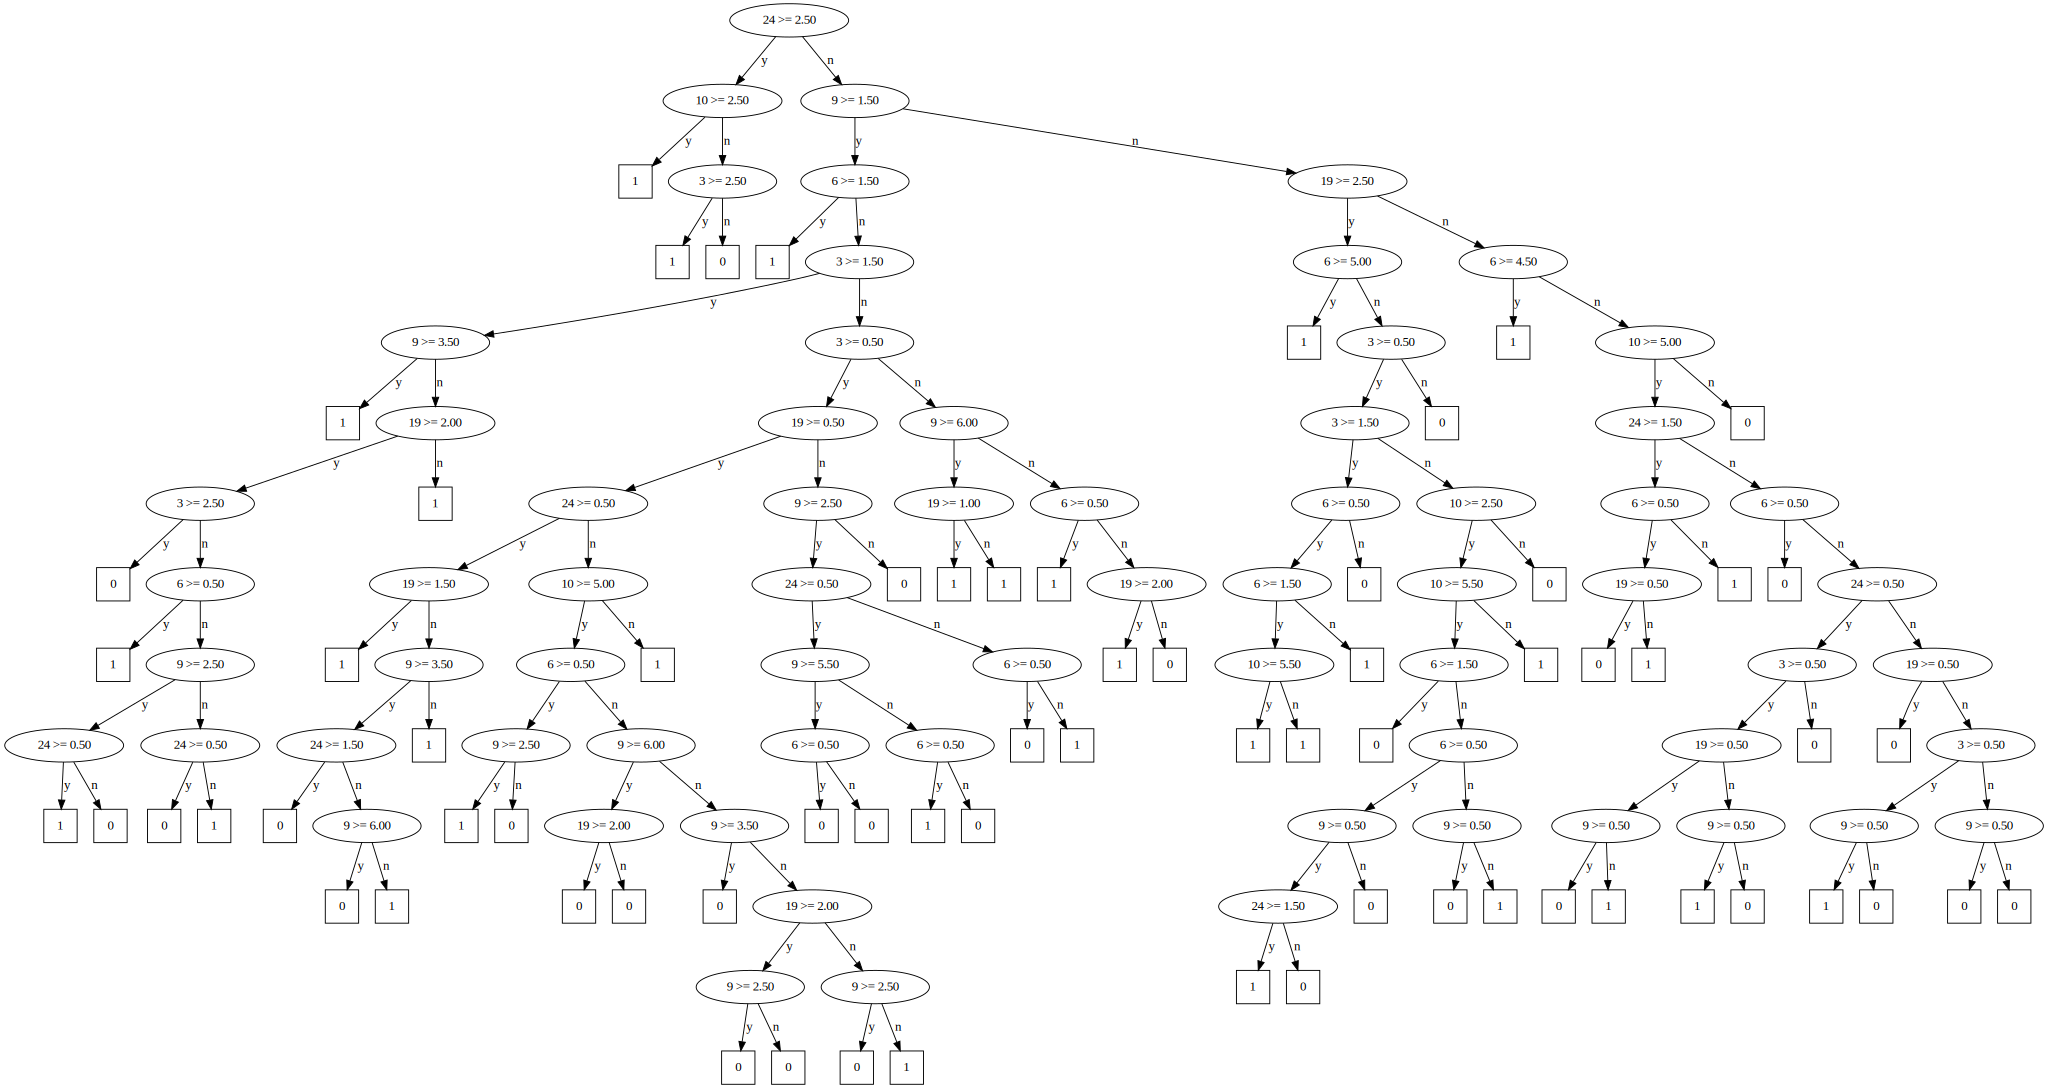

In [30]:
tree_6_g = bfs(tree_6)
tree_6_g

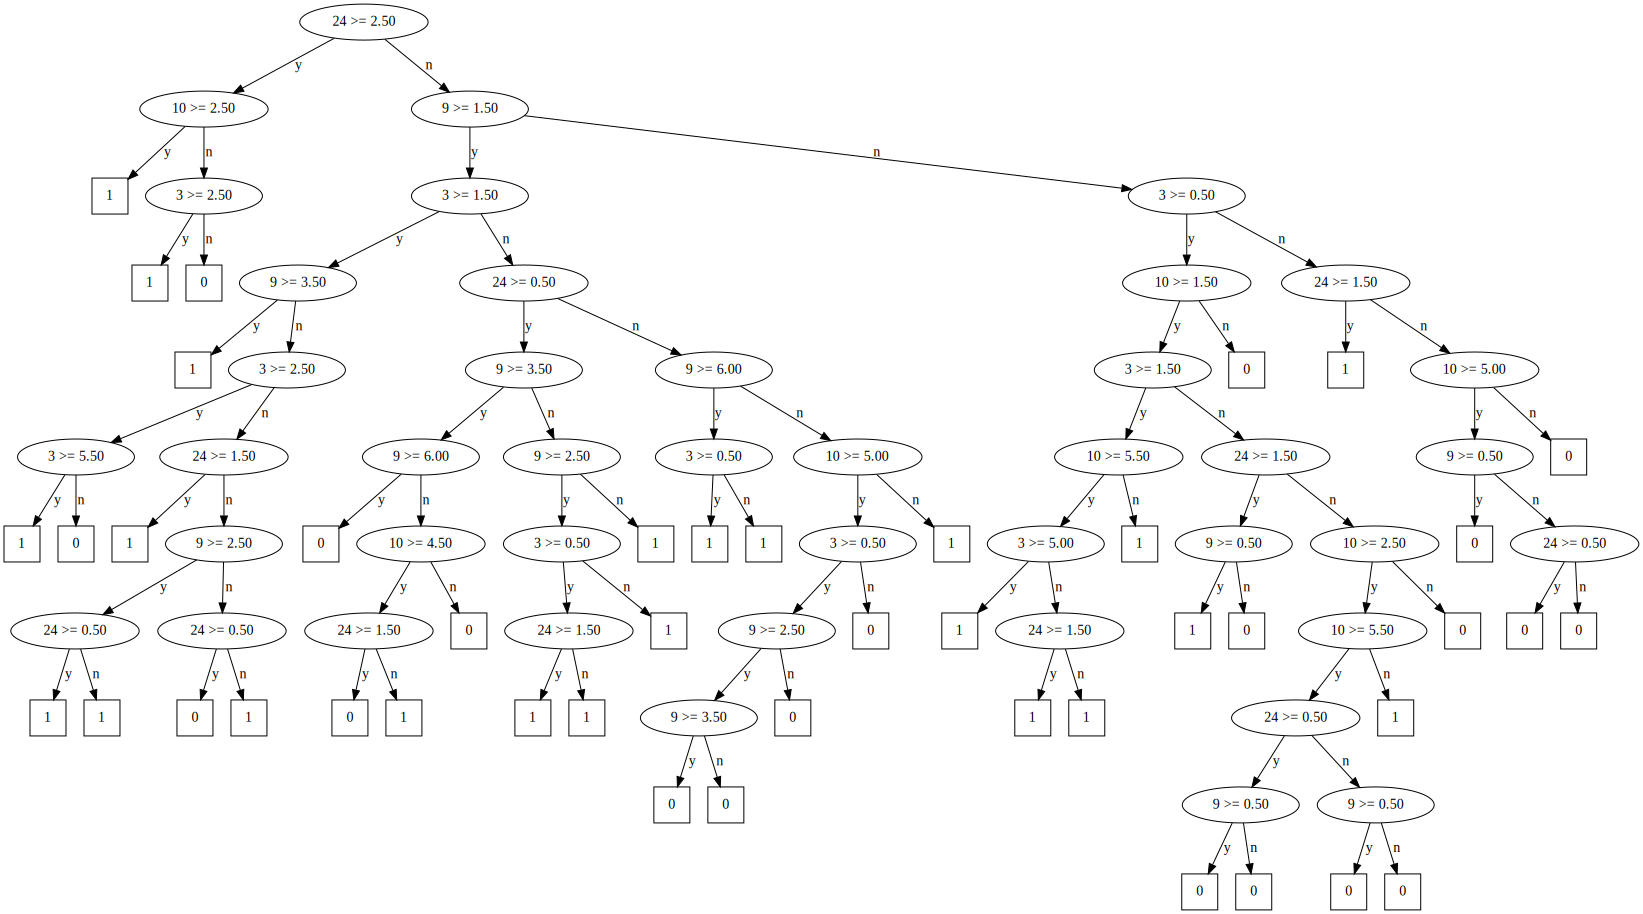

In [31]:
tree_4_g = bfs(tree_4)
tree_4_g

In [32]:
def classify_obs(root, obs):
    cur = root
    while(type(cur) != int):
        #print(cur)
        feature, value = cur.feature, cur.value
        direction = obs[feature] >= value
        if(direction == True):
            #print("Yes")
            cur = cur.yes
        else:
            #print("No")
            cur = cur.no
    
    return cur

In [33]:
def get_predictions(root, data_test):
    preds = []
    for obs in data_test:
        pred = classify_obs(root, obs)
        preds.append(pred)
    return np.array(preds)

def get_accuracy(data_pred_test, data_test):
    mapping = {'asd': 1, 'non-asd': 0, 0:0, 1:1}
    correct = 0
    for pred, obs in zip(data_pred_test, data_test[:, LABEL_IDX]):
        if(pred == mapping[obs]):
            correct += 1
    
    
    return correct / len(data_test)
        

In [34]:
def confusion_matrix(data_pred, data):
    mapping = {'asd': 1, 'non-asd': 0, 0:0, 1:1}
    labels = data[:, LABEL_IDX]
    matrix = np.zeros(4).reshape(2,2)
    #print(labels)
    #print(data_pred)
    for pred, obs in zip(data_pred, labels):
        #print(pred, obs)
        matrix[int(pred)][int(mapping[obs])] += 1
    
    return matrix

def sensitivity(confusion_matrix):
    return confusion_matrix[1, 1] / sum(confusion_matrix[1,:])

def specificity(confusion_matrix):
    return confusion_matrix[0, 0] / sum(confusion_matrix[0, :])

In [35]:
data_pred_test = get_predictions(tree_all, data_test)
tree_all_testacc = get_accuracy(data_pred_test, data_test)

data_pred_train = get_predictions(tree_all, data_train)
tree_all_trainacc = get_accuracy(data_pred_train, data_train)
print("All features: ")
print("Accuracy")
print("Training: %0.2f, Test: %0.2f" %(tree_all_trainacc, tree_all_testacc))

All features: 
Accuracy
Training: 1.00, Test: 0.78


In [36]:
confusion_matrix_test = confusion_matrix(data_pred_test, data_test)
confusion_matrix_train = confusion_matrix(data_pred_train, data_train)
print(confusion_matrix_train)
print(confusion_matrix_test)
sensitivity_test =sensitivity(confusion_matrix_test)
print("Test sensitivity: %0.2f" % sensitivity_test)
sensitivity_train = sensitivity(confusion_matrix_train)
print("Training sensitivity: %0.2f" % sensitivity_train)

specificity_test =specificity(confusion_matrix_test)
print("Test specificity: %0.2f" % specificity_test)
specificity_train = specificity(confusion_matrix_train)
print("Training specificity: %0.2f" % specificity_train)

[[327.   0.]
 [  0. 327.]]
[[91. 34.]
 [11. 65.]]
Test sensitivity: 0.86
Training sensitivity: 1.00
Test specificity: 0.73
Training specificity: 1.00


In [37]:
data_pred_test = get_predictions(tree_8, data_test)
tree_8_testacc = get_accuracy(data_pred_test, data_test)

data_pred_train = get_predictions(tree_8, data_train)
tree_8_trainacc = get_accuracy(data_pred_train, data_train)
print("8 features: ")
print("Accuracy")
print("Training: %0.2f, Test: %0.2f" %(tree_8_trainacc, tree_8_testacc))

8 features: 
Accuracy
Training: 0.98, Test: 0.81


In [38]:
confusion_matrix_test = confusion_matrix(data_pred_test, data_test)
confusion_matrix_train = confusion_matrix(data_pred_train, data_train)
print(confusion_matrix_train)
print(confusion_matrix_test)
sensitivity_test =sensitivity(confusion_matrix_test)
print("Test sensitivity: %0.2f" % sensitivity_test)
sensitivity_train = sensitivity(confusion_matrix_train)
print("Training sensitivity: %0.2f" % sensitivity_train)

specificity_test =specificity(confusion_matrix_test)
print("Test specificity: %0.2f" % specificity_test)
specificity_train = specificity(confusion_matrix_train)
print("Training specificity: %0.2f" % specificity_train)

[[323.   8.]
 [  4. 319.]]
[[94. 31.]
 [ 8. 68.]]
Test sensitivity: 0.89
Training sensitivity: 0.99
Test specificity: 0.75
Training specificity: 0.98


In [39]:
data_pred_test = get_predictions(tree_6, data_test)
tree_6_testacc = get_accuracy(data_pred_test, data_test)

data_pred_train = get_predictions(tree_6, data_train)
tree_6_trainacc = get_accuracy(data_pred_train, data_train)
print("6 features: ")
print("Accuracy")
print("Training: %0.2f, Test: %0.2f" %(tree_6_trainacc, tree_6_testacc))

6 features: 
Accuracy
Training: 0.96, Test: 0.81


In [40]:
confusion_matrix_test = confusion_matrix(data_pred_test, data_test)
confusion_matrix_train = confusion_matrix(data_pred_train, data_train)
print(confusion_matrix_train)
print(confusion_matrix_test)
sensitivity_test =sensitivity(confusion_matrix_test)
print("Test sensitivity: %0.2f" % sensitivity_test)
sensitivity_train = sensitivity(confusion_matrix_train)
print("Training sensitivity: %0.2f" % sensitivity_train)

specificity_test =specificity(confusion_matrix_test)
print("Test specificity: %0.2f" % specificity_test)
specificity_train = specificity(confusion_matrix_train)
print("Training specificity: %0.2f" % specificity_train)

[[321.  20.]
 [  6. 307.]]
[[90. 26.]
 [12. 73.]]
Test sensitivity: 0.86
Training sensitivity: 0.98
Test specificity: 0.78
Training specificity: 0.94


In [41]:
data_pred_test = get_predictions(tree_4, data_test)
tree_4_testacc = get_accuracy(data_pred_test, data_test)

data_pred_train = get_predictions(tree_4, data_train)
tree_4_trainacc = get_accuracy(data_pred_train, data_train)
print("4 features: ")
print("Accuracy")
print("Training: %0.2f, Test: %0.2f" %(tree_4_trainacc, tree_4_testacc))

4 features: 
Accuracy
Training: 0.92, Test: 0.78


In [42]:
confusion_matrix_test = confusion_matrix(data_pred_test, data_test)
confusion_matrix_train = confusion_matrix(data_pred_train, data_train)
print(confusion_matrix_train)
print(confusion_matrix_test)
sensitivity_test =sensitivity(confusion_matrix_test)
print("Test sensitivity: %0.2f" % sensitivity_test)
sensitivity_train = sensitivity(confusion_matrix_train)
print("Training sensitivity: %0.2f" % sensitivity_train)

specificity_test =specificity(confusion_matrix_test)
print("Test specificity: %0.2f" % specificity_test)
specificity_train = specificity(confusion_matrix_train)
print("Training specificity: %0.2f" % specificity_train)

[[313.  36.]
 [ 14. 291.]]
[[87. 30.]
 [15. 69.]]
Test sensitivity: 0.82
Training sensitivity: 0.95
Test specificity: 0.74
Training specificity: 0.90


In [43]:
# test all variables for the best accuracy
trees = []
for x in range(3,11):
    features = select_k_lowest_features(data_train, k=x)
    trees.append(get_decision_tree(data_train, features=features))

Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for leaf node..
Model performing best guess for 

In [44]:
tree_g = []
for x in range(len(trees)):
    tree_g.append(bfs(trees[x]))

In [45]:
i = 3
test_x,test_y = [], []
train_x, train_y = [], []
confusion_matrices_train, confusion_matrices_test = [], []
for tree in trees:
    data_pred_test = get_predictions(tree, data_test)
    data_pred_train = get_predictions(tree, data_train)
    confusion_matrices_train.append(confusion_matrix(data_pred_train, data_train))
    confusion_matrices_test.append(confusion_matrix(data_pred_test, data_test))
    test_accuracy = get_accuracy(data_pred_test, data_test)
    train_accuracy = get_accuracy(data_pred_train, data_train)
    print("Features: %d, Test Accuracy: %0.3f, Train Accuracy: %0.3f" % (i, test_accuracy, train_accuracy))
    test_x.append(i)
    train_x.append(i)
    test_y.append(test_accuracy)
    train_y.append(train_accuracy)
    i+=1

Features: 3, Test Accuracy: 0.811, Train Accuracy: 0.902
Features: 4, Test Accuracy: 0.776, Train Accuracy: 0.924
Features: 5, Test Accuracy: 0.791, Train Accuracy: 0.937
Features: 6, Test Accuracy: 0.811, Train Accuracy: 0.960
Features: 7, Test Accuracy: 0.801, Train Accuracy: 0.977
Features: 8, Test Accuracy: 0.806, Train Accuracy: 0.982
Features: 9, Test Accuracy: 0.806, Train Accuracy: 0.989
Features: 10, Test Accuracy: 0.806, Train Accuracy: 0.992


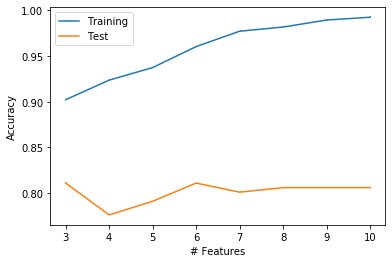

In [46]:
plt.plot(train_x, train_y, marker=',', label='Training')
plt.plot(test_x,test_y, marker=',', label='Test')
plt.xlabel("# Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
i = 3
x_train, x_test = [], []
y_train, y_test = [], []
for c1, c2 in zip(confusion_matrices_train, confusion_matrices_test):
    x_train.append(i)
    x_test.append(i)
    train_specificity = specificity(c1)
    test_specificity = specificity(c2)
    y_train.append(train_specificity)
    y_test.append(test_specificity)
    print("Features: %d, Test Specificity: %0.3f, Train Specificity: %0.3f" % (i, test_specificity, train_specificity))
    i+=1

Features: 3, Test Specificity: 0.781, Train Specificity: 0.873
Features: 4, Test Specificity: 0.744, Train Specificity: 0.897
Features: 5, Test Specificity: 0.763, Train Specificity: 0.923
Features: 6, Test Specificity: 0.776, Train Specificity: 0.941
Features: 7, Test Specificity: 0.754, Train Specificity: 0.970
Features: 8, Test Specificity: 0.752, Train Specificity: 0.976
Features: 9, Test Specificity: 0.774, Train Specificity: 0.985
Features: 10, Test Specificity: 0.769, Train Specificity: 0.985


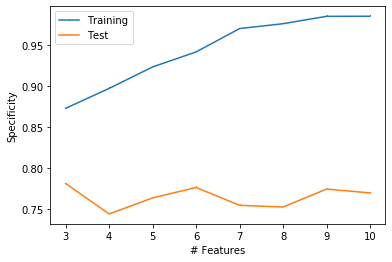

In [48]:
plt.plot(x_train, y_train, marker=',', label='Training')
plt.plot(x_test,y_test, marker=',', label='Test')
plt.xlabel("# Features")
plt.ylabel("Specificity")
plt.legend()
plt.show()

In [49]:
i = 3
x_train, x_test = [], []
y_train, y_test = [], []
for c1, c2 in zip(confusion_matrices_train, confusion_matrices_test):
    x_train.append(i)
    x_test.append(i)
    train_sensitivity = sensitivity(c1)
    test_sensitivity = sensitivity(c2)
    y_train.append(train_sensitivity)
    y_test.append(test_sensitivity)
    print("Features: %d, Test Sensitivity: %0.3f, Train Sensitivity: %0.3f" % (i, test_sensitivity, train_sensitivity))
    i+=1

Features: 3, Test Sensitivity: 0.851, Train Sensitivity: 0.937
Features: 4, Test Sensitivity: 0.821, Train Sensitivity: 0.954
Features: 5, Test Sensitivity: 0.828, Train Sensitivity: 0.953
Features: 6, Test Sensitivity: 0.859, Train Sensitivity: 0.981
Features: 7, Test Sensitivity: 0.873, Train Sensitivity: 0.984
Features: 8, Test Sensitivity: 0.895, Train Sensitivity: 0.988
Features: 9, Test Sensitivity: 0.849, Train Sensitivity: 0.994
Features: 10, Test Sensitivity: 0.857, Train Sensitivity: 1.000


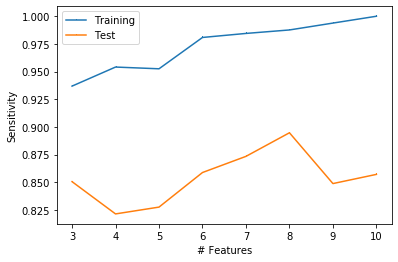

In [50]:
plt.plot(x_train, y_train, marker=',', label='Training')
plt.plot(x_test,y_test, marker=',', label='Test')
plt.xlabel("# Features")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

In [51]:
def vote(preds):
    unique, counts = np.unique(preds, return_counts=True)
    return unique[np.argmax(counts)]

def child_to_prediction_validate(child_to_index, data_pred):
    
    child_to_pred = defaultdict(int)
    
    for child in child_to_index:
        preds = []
        indices = child_to_index[child]
        for index in indices:
            
            preds.append(data_pred[index])
        pred = vote(np.array(preds))
        child_to_pred[child] = pred
    
    return child_to_pred

def get_child_to_prediction(child_to_index, data):
    
    child_to_pred = defaultdict(int)
    
    for child in child_to_index:
        preds = []
        indices = child_to_index[child]
        for index in indices:
            actual = int(data.iloc[index]['ASD'] == 1)
            preds.append(actual)
            
            
        child_to_pred[child] = vote(preds)
    
    return child_to_pred

In [52]:
actual_test = get_child_to_prediction(child_to_index_test, test)
pred_test = get_predictions(tree_all, data_test)

In [53]:
pred_test = child_to_prediction_validate(child_to_index_test, pred_test)

In [54]:
def validate_votes(actual, pred):
    correct = 0
    for c1, c2 in zip(pred, actual):
        if(c1 == c2):
            p1, p2 = pred[c1], actual[c2]
            if(p1 == p2):
                correct += 1
    
    return correct / len(pred)

In [55]:
actual_test = get_child_to_prediction(child_to_index_test, test)
i = 3

x = np.arange(3,11)
y1, y2, y3 = [], [], []

for tree in trees:
    pred_test = get_predictions(tree, data_test)
    
    pred_test = child_to_prediction_validate(child_to_index_test, pred_test)
    
    actual = np.array(list(actual_test.values())).reshape(len(actual_test), 1)
    
    pred = np.array(list(pred_test.values())).reshape(len(actual_test), 1)
    c_matrix = confusion_matrix(pred, actual)
    
    acc = validate_votes(actual_test, pred_test)
    y1.append(acc)
    sens = sensitivity(c_matrix)
    y2.append(sens)
    spec = specificity(c_matrix)
    y3.append(spec)
    
    print("Features: %d, Accuracy: %0.3f, Sensitivity %0.3f, Specificity %0.3f" %(i, acc, sens, spec))
    i+=1
y1, y2, y3 = np.array(y1), np.array(y2), np.array(y3)

Features: 3, Accuracy: 0.866, Sensitivity 0.929, Specificity 0.821
Features: 4, Accuracy: 0.851, Sensitivity 0.897, Specificity 0.816
Features: 5, Accuracy: 0.821, Sensitivity 0.862, Specificity 0.789
Features: 6, Accuracy: 0.851, Sensitivity 0.897, Specificity 0.816
Features: 7, Accuracy: 0.836, Sensitivity 0.923, Specificity 0.780
Features: 8, Accuracy: 0.836, Sensitivity 0.958, Specificity 0.767
Features: 9, Accuracy: 0.851, Sensitivity 0.897, Specificity 0.816
Features: 10, Accuracy: 0.866, Sensitivity 0.929, Specificity 0.821


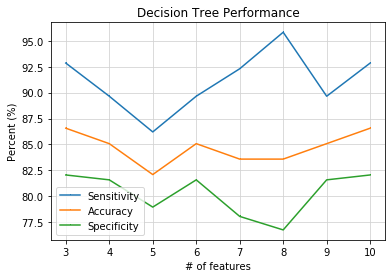

In [56]:
plt.plot(x, y2*100, marker=',', label='Sensitivity')
plt.plot(x, y1*100, marker=',', label='Accuracy')
plt.plot(x, y3*100, marker=',', label='Specificity')
plt.legend()
plt.title("Decision Tree Performance")
plt.xlabel("# of features")
plt.ylabel("Percent (%)")
plt.grid(linestyle='-', color='lightgray')
plt.savefig('decisiontreeperformance.png')
plt.show()

Is treating variables as categorical better?

In [57]:
from collections import defaultdict
def get_data_partitions(data, features=None):
    
    #all features
    if(features == None):
        features = np.arange(0, data.shape[1]-1)
        
    partitions = defaultdict(list)
    for idx in range(0, data.shape[1]-1):
        # one of selected features?
        if(idx in features):
            unique_scores = np.unique(data[:, idx])
            '''
            if(len(unique_scores) == 1): # edge case what if unique score == 1
                partitions[idx].append(unique_scores[0])
            '''
            for score in unique_scores:
                partitions[idx].append(score)
        else:
            continue
        
    return partitions

def partition_data(data, question, score):
    a,b = data[data[:, question] == score], data[data[:, question] != score]
    
    return a,b

class TreeNode(object):
    def __init__(self, feature, value, id=None):
        self.question = "%s == %0.2f" % (feature, value)
        self.feature = feature
        self.value = value
        self.yes = None
        self.no = None
        self.id = id
    
    def __str__(self):
        return self.question
    
    def set_id(self, id):
        self.id = id
    def get_id(self):
        return str(self.id)



In [58]:
attributes_train = ['child_id', 'scorer_id', 'question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'diag']
attributes_test = ['child_id', 'scorer_id', 'question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'ASD']
train, test = pd.read_csv('./Tariq-Wall-2018-PLOS-MEDICINE/datasets/primary_dataset.csv'), pd.read_csv('./Tariq-Wall-2018-PLOS-MEDICINE/datasets/validation_dataset.csv')
train, test = train[attributes_train], test[attributes_test]

In [59]:
to_remove = remove_nan(train)
train.drop(to_remove, inplace=True)

In [60]:
to_remove = remove_underrepresented_data(train)
train.drop(to_remove, inplace=True)

to_remove = remove_underrepresented_data(test)
test.drop(to_remove, inplace=True)
child_to_index_train = get_children_to_index(train)
child_to_index_test = get_children_to_index(test)
#child_to_index_test = get_children_to_index(test)

attributes_test = ['question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'ASD']
test = test[attributes_test]

attributes_train = ['question1', 'question2', 'question3', 'question4', 'question5', 'question6', 'question7', 'question8', 'question9', 'question10', 'question11', 'question12', 'question13', 'question14', 'question15', 'question16', 'question17', 'question18', 'question19', 'question20', 'question21', 'question22', 'question23', 'question24', 'question25', 'question26', 'question27', 'question28', 'question29', 'question30', 'diag']
train = train[attributes_train]
train.shape, test.shape

((480, 31), (201, 31))

In [61]:
sample = upsample(train)

for idx in sample: # hacky way to append to pandas dataframe without copying..
    train.loc[train.index.max() + 1] = train.loc[idx]

In [62]:
# populations equally represented now??
assert(train.loc[train['diag'] == 'asd'].shape == train.loc[train['diag'] == 'non-asd'].shape)
print(train.shape)
print(test.shape)

(654, 31)
(201, 31)


In [63]:
data_train, data_test = train.values, test.values

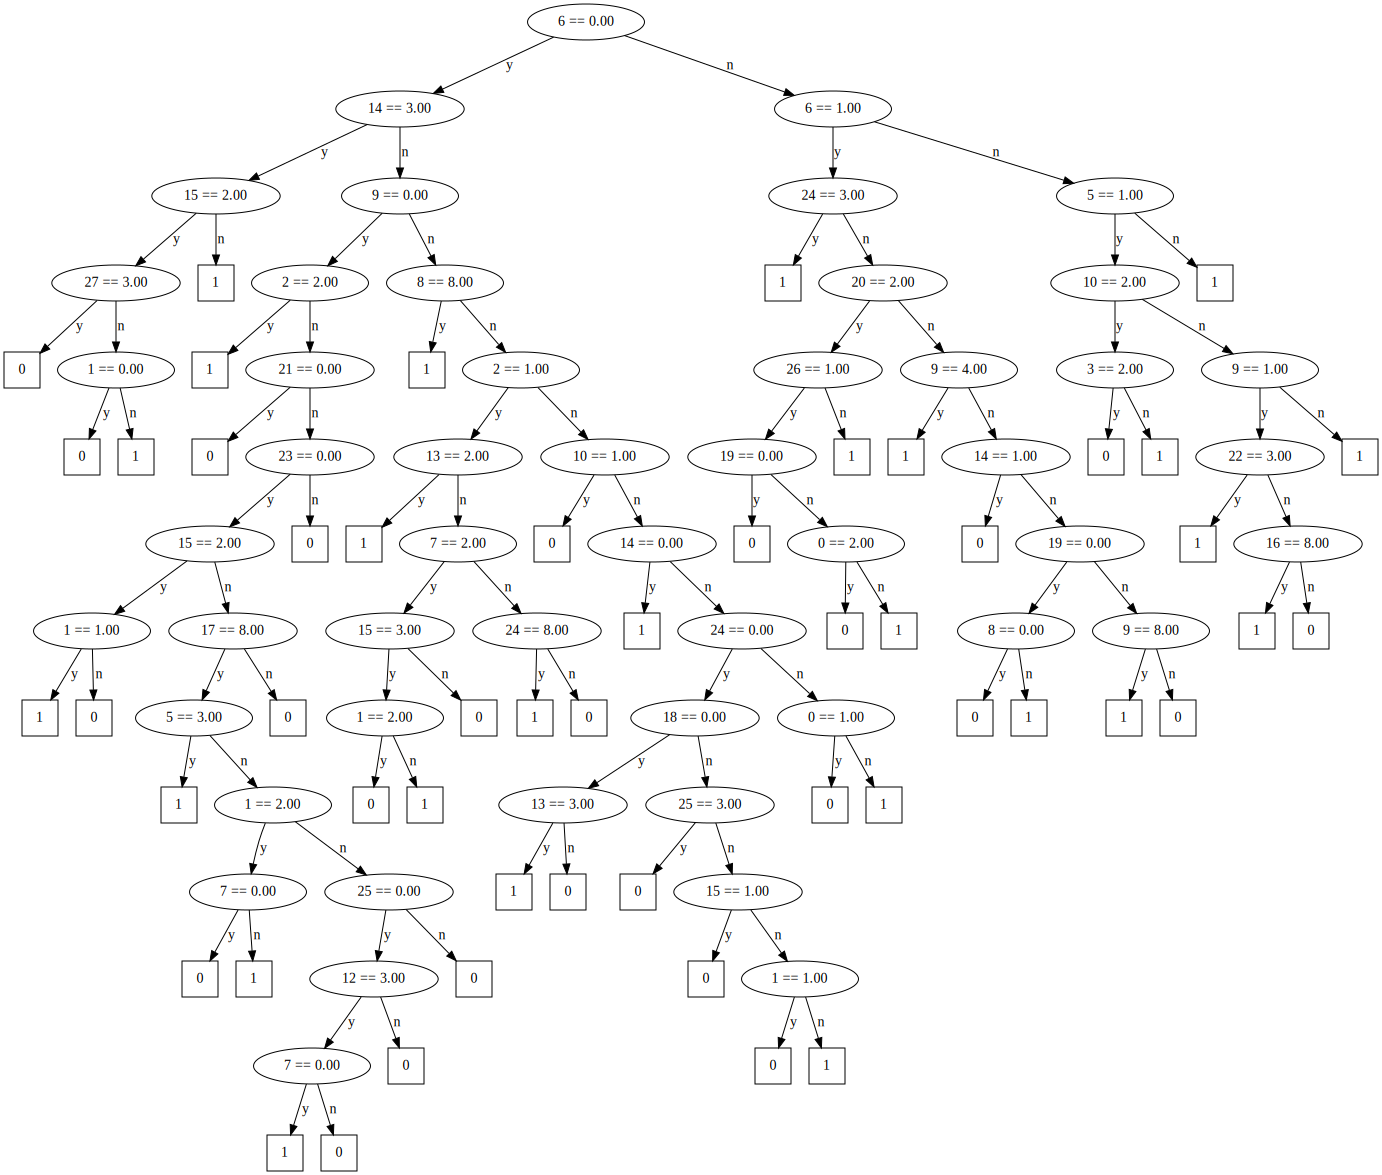

In [64]:
tree_all = get_decision_tree(data_train)
tree_all_g = bfs(tree_all)
tree_all_g

In [65]:
data_pred_test = get_predictions(tree_all, data_test)
tree_all_testacc = get_accuracy(data_pred_test, data_test)

data_pred_train = get_predictions(tree_all, data_train)
tree_all_trainacc = get_accuracy(data_pred_train, data_train)
print("All features: ")
print("Accuracy")
print("Training: %0.2f, Test: %0.2f" %(tree_all_trainacc, tree_all_testacc))

All features: 
Accuracy
Training: 0.84, Test: 0.67
